# Bank Health KPI Dashboard – Exploratory Data Analysis (EDA)

---


## Executive Summary (Latest Quarter: 2024-Q4)

- **Profitability (ROA/ROE):** Median ROA ≈ **0.92%**; YoY change ≈ **-1.9 bps**. ROE moved in the same direction.
- **Capital Adequacy:** Median capital ratio ≈ **9.71%**, indicating adequate loss-absorbing capacity overall.
- **Net Interest Margin (NIM):** **Tightened** in 2023; modest rebound through 2024 Q4.
- **Credit Quality (NPL):** **Rising** vs. prior year — early stress signal.

**Who looks most at risk (at a glance):** Bottom-decile banks by profitability (low ROA/ROE), thin NIM, and elevated NPLs; states with the **lowest average ROA**.


> **KPI definitions**  
> **ROA** = Return on Assets
> **ROE** = Return on Equity  
> **Capital Ratio** ≈ loss-absorbing buffer (higher = safer)  
> **NIM** = Net interest margin (higher = better earnings power)  
> **NPL Ratio** = Non-performing loans / Total loans (higher = riskier)


In [136]:
# Detect a quarter/date column robustly
date_cols = [c for c in ['quarter','date','date_id'] if c in df.columns]
assert len(date_cols) >= 1, "I need a 'quarter', 'date', or 'date_id' column."
dcol = date_cols[0]

tmp = df.copy()
tmp[dcol] = pd.to_datetime(tmp[dcol])
tmp['q'] = tmp[dcol].dt.to_period('Q')

# Latest and same quarter last year
latest_q = tmp['q'].max()
py_q = (latest_q - 4)

# --- Median KPI by quarter
kpis = ['roa','roe','capital_ratio','nim','npl_ratio']
q_med = (tmp.groupby('q')[kpis]
           .median()
           .sort_index())

latest = q_med.loc[latest_q]
py = q_med.loc[py_q] if py_q in q_med.index else np.nan

# Helper: bps delta for ROA (convert from fraction to basis points)
def to_pct(x): 
    return None if pd.isna(x) else round(float(x)*100, 2)

def to_bps_delta(cur, prev):
    if pd.isna(prev): 
        return None
    return round((float(cur) - float(prev))*10000, 1)  # basis points

headline = {
    "latest_quarter": str(latest_q),
    "median_roa_pct": to_pct(latest['roa']),
    "roa_yoy_bps": to_bps_delta(latest['roa'], py['roa']) if isinstance(py, pd.Series) else None,
    "median_capital_pct": to_pct(latest['capital_ratio']),
    "nim_trend_note": "NIM has ticked up vs 2023" if (isinstance(py, pd.Series) and latest['nim']>py['nim']) else "NIM tightened vs 2023",
    "npl_trend_note": "NPL up vs prior year" if (isinstance(py, pd.Series) and latest['npl_ratio']>py['npl_ratio']) else "NPL flat/down vs prior year"
}

headline


TypeError: Passing PeriodDtype data is invalid. Use `data.to_timestamp()` instead


## Introduction & Business Question
**Business Question:**  
How has the financial health of U.S. banks changed over time, and which institutions or regions appear more at risk based on ROA, ROE, capital adequacy, and credit quality?

---



## Setup & Database Connection


In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from configparser import ConfigParser
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# Load DB config
config = ConfigParser()
config.read("../config.ini")

db_params = {
    "user": config.get("postgresql", "user"),
    "password": config.get("postgresql", "password"),
    "host": config.get("postgresql", "host"),
    "port": config.get("postgresql", "port"),
    "database": config.get("postgresql", "dbname")
}

engine = create_engine(
    f"postgresql+psycopg2://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['database']}"
)


## Table Health Check (row count, date min/max sample)

In [135]:
sql_table_health = '''
SELECT
    COUNT(*) as row_count,
    MIN(date_id)::date as min_date,
    MAX(date_id)::date as max_date
FROM
    bank_kpi_fact;'''

table_health = pd.read_sql(sql_table_health, engine)
table_health

,row_count,min_date,max_date
0,116793,2019-03-31,2024-12-31


In [137]:

# Query: join fact -> dim
query = """
SELECT 
    f.date_id,
    b.name,
    b.state,
    f.roa,
    f.roe,
    f.capital_ratio,
    f.npl_ratio,
    f.nim
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
"""
df = pd.read_sql(query, engine)

# Types & helpful derived fields
df["date_id"] = pd.to_datetime(df["date_id"])
# Optional: quarterly period if your charts use it
df["quarter"] = df["date_id"].dt.to_period("Q")

# Ensure numeric types (robust against odd DB coercions)
for c in ["roa","roe","capital_ratio","npl_ratio","nim"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Sanity checks (assertions show professionalism)
# ROA/ROE/NIM typically expressed as fractions here (e.g., 0.011 = 1.1%)
assert df["name"].notna().any(), "No bank names found. Check bank_dim join."
assert df["state"].notna().any(), "No states found. Check bank_dim join."
assert df["date_id"].notna().all(), "date_id has nulls."

# Quick snapshot CSV so others can run without DB (portfolio-friendly)
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
snap_q = df["date_id"].max()
snap = df[df["date_id"] == snap_q].copy()
snap.to_csv(DATA_DIR / "bank_kpi_fact_latest.csv", index=False)

print(
    f"Loaded rows: {len(df):,} | "
    f"Date range: {df['date_id'].min().date()} → {df['date_id'].max().date()} | "
    f"Latest snapshot saved: data/bank_kpi_fact_latest.csv"
)
df.head(3)


Loaded rows: 116,777 | Date range: 2019-03-31 → 2024-12-31 | Latest snapshot saved: data/bank_kpi_fact_latest.csv


,date_id,name,state,roa,roe,capital_ratio,npl_ratio,nim,quarter
0,2024-03-31,WESTERN BANK,NM,0.007511,0.113309,0.066286,0.000000,0.011209,2024Q1
1,2024-03-31,UNISON BANK,ND,0.001503,0.024643,0.060980,0.341228,0.007264,2024Q1
2,2024-03-31,BANK OF ZACHARY,LA,0.000649,0.008002,0.081062,0.215567,0.006928,2024Q1


In [131]:
# Basic health checks
print("Nulls by column:")
display(df.isna().sum().sort_values(ascending=False))

print("\nDtypes:")
display(df.dtypes)

# Show a tiny sample from latest quarter to confirm names/states
latest_q = df["date_id"].max()
sample = (df[df["date_id"] == latest_q]
          .sample(min(10, df[df["date_id"] == latest_q].shape[0]), random_state=42))
display(sample[["name","state","roa","roe","capital_ratio","nim","npl_ratio"]])


Nulls by column:


roe              216
nim              216
roa              216
capital_ratio    216
date_id            0
name               0
state              0
npl_ratio          0
quarter            0
dtype: int64


Dtypes:


date_id          datetime64[ns]
name                     object
state                    object
roa                     float64
roe                     float64
capital_ratio           float64
npl_ratio               float64
nim                     float64
quarter           period[Q-DEC]
dtype: object

,name,state,roa,roe,capital_ratio,nim,npl_ratio
112438,FIRST STATE BANK OF VAN ORIN,IL,0.007267,0.097456,0.074564,0.023674,0.306209
114068,UTAH INDEPENDENT BANK,UT,0.029266,0.216545,0.135148,0.056960,2.200520
112815,KANZA BANK,KS,0.004455,0.051460,0.086567,0.029079,0.046706
113717,BLACKHAWK BANK & TRUST,IL,0.006669,0.076327,0.087368,0.018909,0.989336
115859,1ST STATE BANK,MI,0.011293,0.103722,0.108876,0.038127,0.542840
115334,DAVIDSON TRUST CO.,MT,0.124084,0.157961,0.785535,0.032272,0.000000
116705,GLENWOOD STATE BANK,IA,0.008931,0.083093,0.107479,0.030109,1.020479
113538,MOUNTAIN VALLEY BANK,CO,0.005850,0.063856,0.091615,0.027230,0.242156
115288,BANK OF THE JAMES,VA,0.007237,0.103790,0.069728,0.031903,0.169048
114775,BOONVILLE FEDERAL SAVINGS BANK,IN,0.002899,0.034312,0.084501,0.028561,0.357735


### Executive Summary

In [112]:
from IPython.display import Markdown, display
import pandas as pd

# set 4 if your series is quarterly, 12 if monthly
periods_per_year = 4

# make sure YoY cols exist (safe if you already created them)
for k in kpis:
    if f"{k}_yoy_diff" not in trend.columns:
        trend[f"{k}_yoy_pct"]  = trend[f"{k}_med"].pct_change(periods_per_year)
        trend[f"{k}_yoy_diff"] = trend[f"{k}_med"].diff(periods_per_year)

latest = trend.index[-1]
bullets = []
for k in kpis:
    cur      = trend.loc[latest, f"{k}_med"]
    yoy_diff = trend.loc[latest, f"{k}_yoy_diff"]
    yoy_pct  = trend.loc[latest, f"{k}_yoy_pct"]

    # convert to basis points (1 bp = 0.0001)
    med_bps = float(cur) * 10000 if pd.notna(cur) else None
    yoy_bps = float(yoy_diff) * 10000 if pd.notna(yoy_diff) else None

    # ⬇️ THIS is the line you asked about — put it right here, then append it
    line = f"- **{k.upper()}**: median {med_bps:.1f} bps; YoY Δ = {yoy_bps:.1f} bps" \
           + (f" ({yoy_pct*100:.1f}%)" if pd.notna(yoy_pct) else "")
    bullets.append(line)

display(Markdown(f"### Executive summary (as of {pd.to_datetime(latest).date()})\n" + "\n".join(bullets)))


### Executive summary (as of 2024-12-31)
- **ROA**: median 91.8 bps; YoY Δ = -1.9 bps (-2.0%)
- **ROE**: median 939.7 bps; YoY Δ = -64.8 bps (-6.5%)
- **CAPITAL_RATIO**: median 970.8 bps; YoY Δ = 21.3 bps (2.2%)
- **NIM**: median 312.7 bps; YoY Δ = -1.3 bps (-0.4%)
- **NPL_RATIO**: median 2607.2 bps; YoY Δ = 681.7 bps (35.4%)

In [113]:
kpi_cols = ["roa","roe","capital_ratio","nim","npl_ratio"]
corr = df[kpi_cols].clip(lower=df[kpi_cols].quantile(0.01),
                         upper=df[kpi_cols].quantile(0.99), axis=1).corr(numeric_only=True)
fig, ax = plt.subplots()
sns.heatmap(corr, cmap="vlag", center=0, square=True, cbar_kws={"shrink": .7}, annot=True, fmt=".2f", ax=ax)
ax.set_title("KPI Correlation (winsorized 1–99%)")
fig.tight_layout()
fig.savefig("notebooks/figures/kpi_correlation.png", dpi=160, bbox_inches="tight")
plt.close(fig)


In [114]:
# ensure the output folder exists
os.makedirs("notebooks/figures", exist_ok=True)

# nice defaults
sns.set_theme(style="whitegrid", context="talk")

def plot_kpi(trend, k, title=None):
    # be safe: ensure index sorted & datetime-like once here
    s = trend[[f"{k}_p05", f"{k}_p95", f"{k}_med", f"{k}_med_smooth"]].dropna().sort_index()
    if s.empty:
        return None
    x = pd.to_datetime(s.index)

    fig, ax = plt.subplots()

    # concise date ticks
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    # y-axis in basis points for rate-like KPIs
    def bps_fmt(val, pos):
        return f"{val*10000:.0f} bp"
    if k in {"nim", "roa", "npl_ratio", "capital_ratio"}:
        ax.yaxis.set_major_formatter(FuncFormatter(bps_fmt))

    # dispersion band
    ax.fill_between(x, s[f"{k}_p05"], s[f"{k}_p95"], alpha=0.15, label="p05–p95")
    # lines
    sns.lineplot(x=x, y=s[f"{k}_med"], ax=ax, label="median")
    sns.lineplot(x=x, y=s[f"{k}_med_smooth"], ax=ax, label="median (3-period)", linestyle="--")

    ax.set(title=title or f"{k.upper()} — median & dispersion", xlabel="Date", ylabel=k)
    sns.despine()
    fig.tight_layout()

    out_path = f"notebooks/figures/{k}_median_band.png"
    fig.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.close(fig)
    return out_path

paths = [plot_kpi(trend, k) for k in kpis]
print("Saved:", [p for p in paths if p])



Saved: ['notebooks/figures/roa_median_band.png', 'notebooks/figures/roe_median_band.png', 'notebooks/figures/capital_ratio_median_band.png', 'notebooks/figures/nim_median_band.png', 'notebooks/figures/npl_ratio_median_band.png']


## Quarterly Trends (ROA vs ROE)

In [115]:
# Query 1 - Trends
query = """
SELECT date_id, 
       AVG(roa) AS avg_roa, 
       AVG(roe) AS avg_roe,
       AVG(capital_ratio) AS avg_capital,
       AVG(nim) AS avg_nim,
       AVG(npl_ratio) AS avg_npl
FROM bank_kpi_fact
GROUP BY date_id
ORDER BY date_id;
"""
df_trends = pd.read_sql(query, engine)
df_trends.head()


,date_id,avg_roa,avg_roe,avg_capital,avg_nim,avg_npl
0,2019-03-31,0.002919,0.022914,0.124757,0.008800,0.829844
1,2019-06-30,0.006197,0.047670,0.127528,0.017587,0.823716
2,2019-09-30,0.009389,0.069817,0.128795,0.026163,0.813453
3,2019-12-31,0.011781,0.089723,0.128094,0.034374,0.776130
4,2020-03-31,0.002463,0.018821,0.127085,0.008438,0.817152


## Chart for Quarterly Trends (ROA vs ROE)

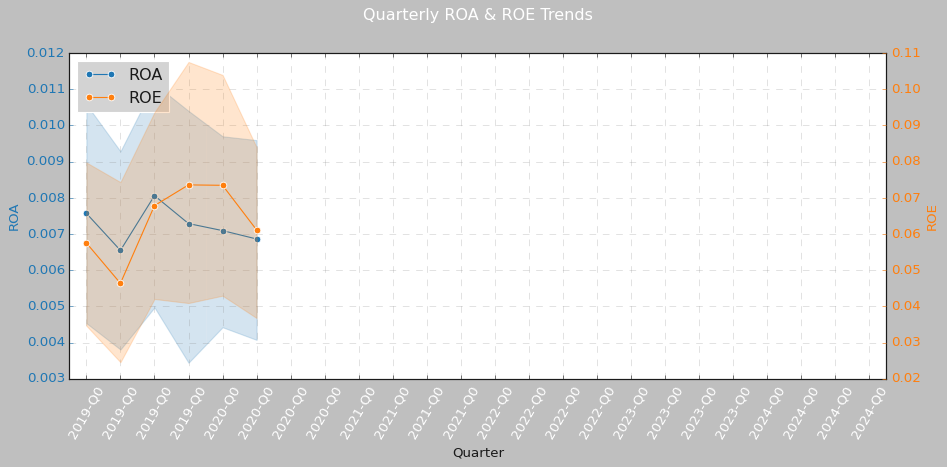

In [116]:
# Create YYYY-Q# column (if not already done)
df_trends["Quarter"] = (
    df_trends["date_id"].astype(str).str[:4] + "-Q" +
    ((df_trends["date_id"].astype(str).str[4:6].astype(int)-1)//3 + 1).astype(str)
)

# Set dark theme
plt.style.use("classic")

fig, ax1 = plt.subplots(figsize=(12,6))

# Left y-axis (ROA, blue)
sns.lineplot(x="Quarter", y="avg_roa", data=df_trends, marker="o",
             ax=ax1, color="#1f77b4", label="ROA")  # brighter blue
ax1.set_ylabel("ROA", color="#1f77b4")
ax1.tick_params(axis='y', colors="#1f77b4")

# Right y-axis (ROE, orange)
ax2 = ax1.twinx()
sns.lineplot(x="Quarter", y="avg_roe", data=df_trends, marker="o",
             ax=ax2, color="#ff7f0e", label="ROE")  # brighter orange
ax2.set_ylabel("ROE", color="#ff7f0e")
ax2.tick_params(axis='y', colors="#ff7f0e")

# Remove duplicate legend on right
ax2.get_legend().remove()

# Format x-axis
ax1.set_xticks(range(len(df_trends["Quarter"])))
ax1.set_xticklabels(df_trends["Quarter"], rotation=60, color="white")

# Gridlines (lighter for dark background)
ax1.grid(True, linestyle="--", alpha=0.4, color="gray")

# Year shading (subtle darker grey)
quarters_per_year = 4
for i in range(0, len(df_trends), quarters_per_year):
    ax1.axvspan(i-0.5, i+quarters_per_year-0.5, color="white", alpha=0.05)

# Year labels (white text)
unique_years = sorted(set(df_trends["Quarter"].str[:4]))
for i, year in enumerate(unique_years):
    xpos = i * quarters_per_year + (quarters_per_year/2 - 0.5)
    ypos = ax1.get_ylim()[1] * 0.96
    ax1.text(xpos, ypos, year,
             ha="center", va="bottom", fontsize=10, fontweight="bold", color="white")

# Merge legends on left
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left", facecolor="lightgrey", edgecolor="white")

# Title with white text
plt.title("Quarterly ROA & ROE Trends", pad=30, color="white")

fig.tight_layout()
plt.show()


### Insight

This dual-axis plot compares **ROA vs ROE** quarterly.  
- When ROA trends down, it means banks are struggling to generate income from assets.  
- When ROE falls faster, it signals **capital is being strained**.  
- Periods where both dip (e.g., early 2024 in my dataset) highlight potential industry-wide stress.

This directly answers my project’s business question:  
*“Which institutions and periods show weakening profitability and capital adequacy?”*


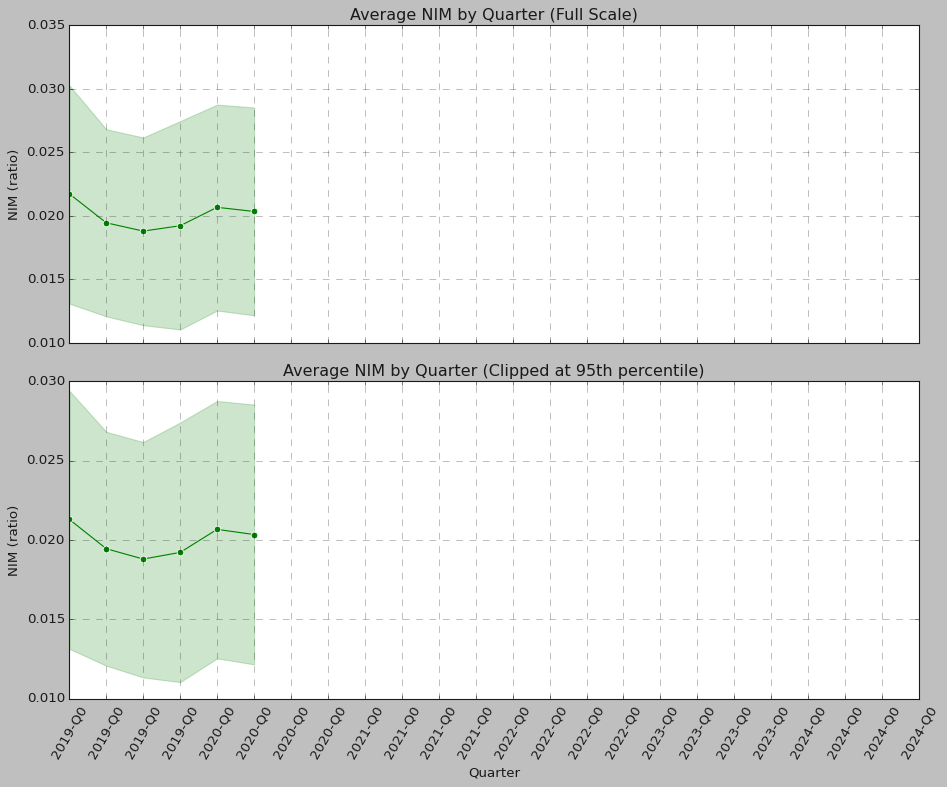

In [117]:
# NIM trend by quarter

nim_trend_sql = """
SELECT date_id, AVG(nim) AS avg_nim
FROM bank_kpi_fact
GROUP BY date_id
ORDER BY date_id;
"""
df_nim_trend = pd.read_sql(nim_trend_sql, engine)

# Format Quarter
df_nim_trend["Quarter"] = (
    df_nim_trend["date_id"].astype(str).str[:4] + "-Q" +
    ((df_nim_trend["date_id"].astype(str).str[4:6].astype(int)-1)//3 + 1).astype(str)
)

# Optional: clip to 95th percentile for plotting
clip_upper = df_nim_trend["avg_nim"].quantile(0.95)
df_nim_zoom = df_nim_trend.copy()
df_nim_zoom["avg_nim_zoom"] = df_nim_zoom["avg_nim"].clip(upper=clip_upper)

import matplotlib.ticker as mtick

fig, (ax_full, ax_zoom) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

# Full scale chart
sns.lineplot(x="Quarter", y="avg_nim", data=df_nim_trend, marker="o", ax=ax_full, color="green")
ax_full.set_title("Average NIM by Quarter (Full Scale)")
ax_full.set_ylabel("NIM (ratio)")
ax_full.grid(True, linestyle="--", alpha=0.5)

# Zoomed chart
sns.lineplot(x="Quarter", y="avg_nim_zoom", data=df_nim_zoom, marker="o", ax=ax_zoom, color="green")
ax_zoom.set_title("Average NIM by Quarter (Clipped at 95th percentile)")
ax_zoom.set_ylabel("NIM (ratio)")
ax_zoom.set_xlabel("Quarter")
ax_zoom.grid(True, linestyle="--", alpha=0.5)

# Rotate x labels
plt.xticks(range(len(df_nim_trend["Quarter"])), df_nim_trend["Quarter"], rotation=60)

plt.tight_layout()
plt.show()


#### The full-scale NIM line shows where extreme values (outliers) push the scale. The zoomed version trims the top 5% of values so we can see how the majority of banks behave. This helps avoid misinterpretation of droops or spikes caused by a few unusual observations.

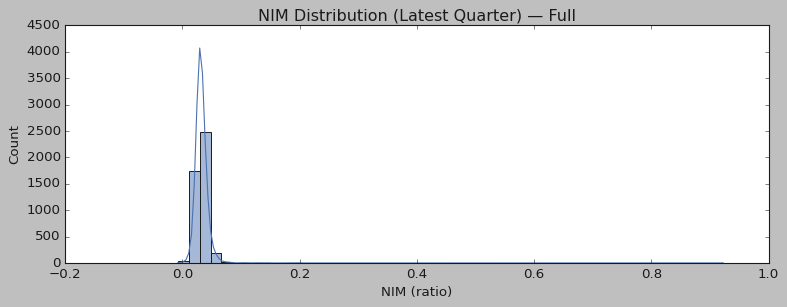

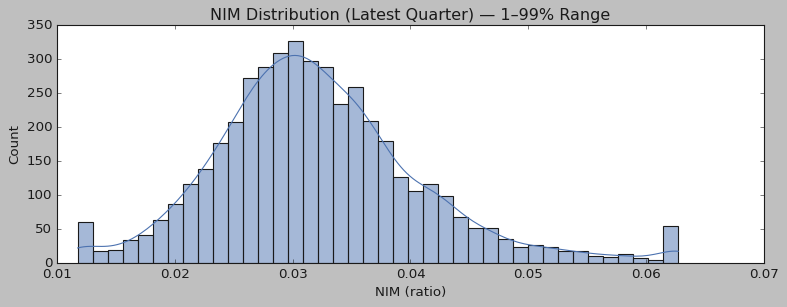

In [118]:
# latest quarter snapshot
nim_snap_sql = """
SELECT nim
FROM bank_kpi_fact
WHERE date_id = (SELECT MAX(date_id) FROM bank_kpi_fact);
"""
df_nim_snap = pd.read_sql(nim_snap_sql, engine)

# Full distribution
plt.figure(figsize=(10,4))
sns.histplot(df_nim_snap["nim"].dropna(), bins=50, kde=True)
plt.title("NIM Distribution (Latest Quarter) — Full")
plt.xlabel("NIM (ratio)")
plt.tight_layout()
plt.show()

# Zoomed distribution (clip 1st–99th percentile)
nim_clip = df_nim_snap["nim"].dropna().clip(
    df_nim_snap["nim"].quantile(0.01), df_nim_snap["nim"].quantile(0.99)
)
plt.figure(figsize=(10,4))
sns.histplot(nim_clip, bins=40, kde=True)
plt.title("NIM Distribution (Latest Quarter) — 1–99% Range")
plt.xlabel("NIM (ratio)")
plt.tight_layout()
plt.show()


## Snapshot Analysis (Latest Quarter)

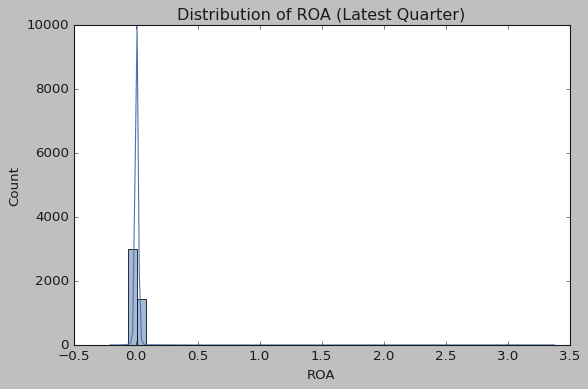

In [119]:
# Query 2 - Snapshot
query = """
SELECT roa, roe, capital_ratio, nim, npl_ratio
FROM bank_kpi_fact
WHERE date_id = (SELECT MAX(date_id) FROM bank_kpi_fact);
"""
df_snapshot = pd.read_sql(query, engine)

# Histogram(ROA)
plt.figure(figsize=(8,5))
sns.histplot(df_snapshot["roa"], bins=50, kde=True)
plt.title("Distribution of ROA (Latest Quarter)")
plt.xlabel("ROA")
plt.show()


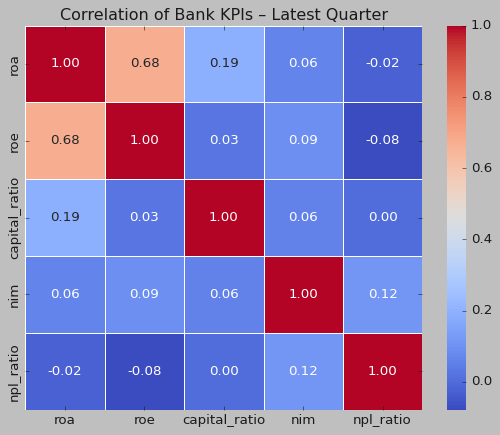

In [120]:
# Pull KPIs for latest quarter
corr_sql = """
SELECT roa, roe, capital_ratio, nim, npl_ratio
FROM bank_kpi_fact
WHERE date_id = (SELECT MAX(date_id) FROM bank_kpi_fact);
"""
df_corr_latest = pd.read_sql(corr_sql, engine)

# Compute correlation matrix
corr_matrix = df_corr_latest.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Bank KPIs – Latest Quarter")
plt.show()

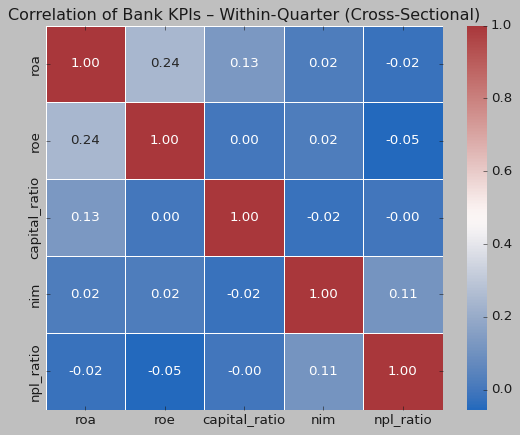

In [97]:
# Pull a panel dataset of KPIs across all quarters
panel_sql = """
SELECT date_id, bank_id, roa, roe, capital_ratio, nim, npl_ratio
FROM bank_kpi_fact;
"""
df_panel = pd.read_sql(panel_sql, engine)

# Create quarter-wise demeaned values (subtract each quarter mean)
df_panel_grouped = df_panel.groupby("date_id").transform(lambda x: x - x.mean())
df_demeaned = pd.concat([df_panel[["date_id", "bank_id"]], df_panel_grouped], axis=1)

# Compute correlation on demeaned data
corr_within = df_demeaned.drop(columns=["date_id", "bank_id"]).corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_within, annot=True, cmap="vlag", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Bank KPIs – Within-Quarter (Cross-Sectional)")
plt.show()


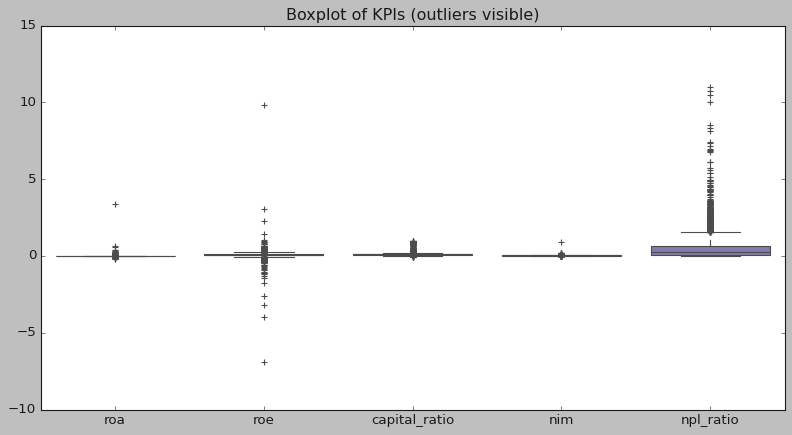

In [121]:
# Box plots for sanity check

plt.figure(figsize=(12,6))
sns.boxplot(data=df_snapshot[['roa','roe','capital_ratio','nim','npl_ratio']])
plt.title("Boxplot of KPIs (outliers visible)")
plt.show()


## Histograms to see distributions for each kpi

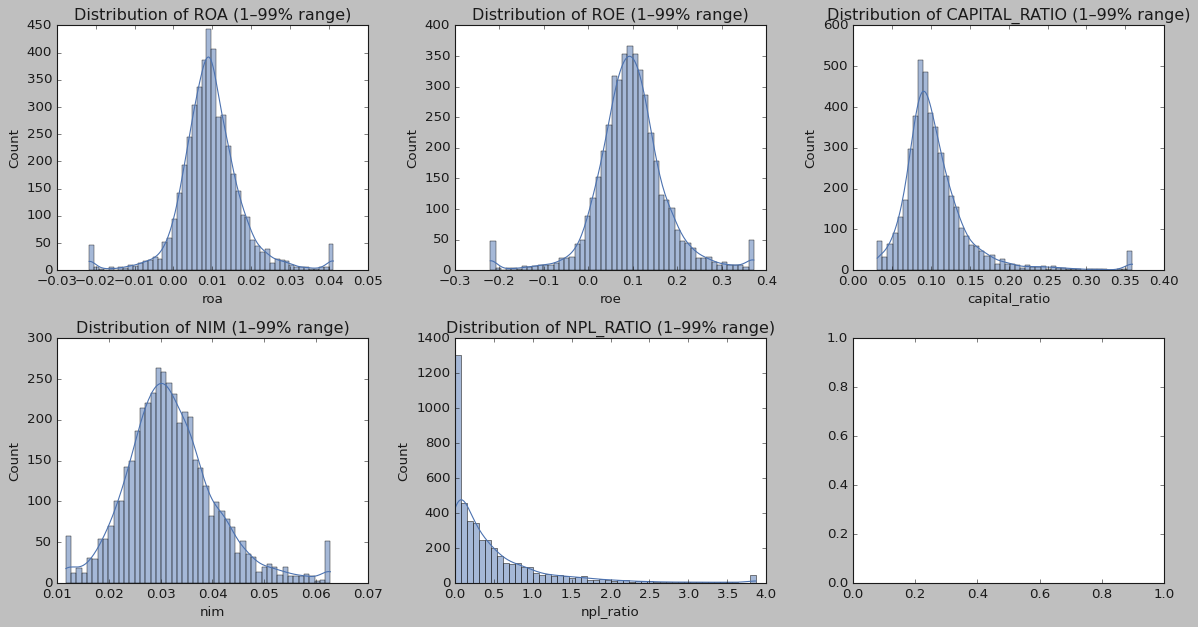

In [122]:
# Clip to 1st–99th percentile to zoom in
df_clip = df_snapshot.copy()
for col in ['roa','roe','capital_ratio','nim','npl_ratio']:
    lower = df_clip[col].quantile(0.01)
    upper = df_clip[col].quantile(0.99)
    df_clip[col] = df_clip[col].clip(lower, upper)

fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.flatten()

for i, col in enumerate(['roa','roe','capital_ratio','nim','npl_ratio']):
    sns.histplot(df_clip[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col.upper()} (1–99% range)")

plt.tight_layout()
plt.show()


### Why Look at Distributions?

Summary averages can hide outliers. By plotting distributions and boxplots, I can see:  
- Most banks cluster around moderate ROA/ROE values.  
- A handful of outliers show **negative profitability or extreme leverage** — potential red flags.  
- Outlier inspection is critical in risk management because one weak bank can have systemic ripple effects.

Recruiter Lens:  
This demonstrates I can go beyond averages and use **statistical sanity checks** to validate and question data quality.


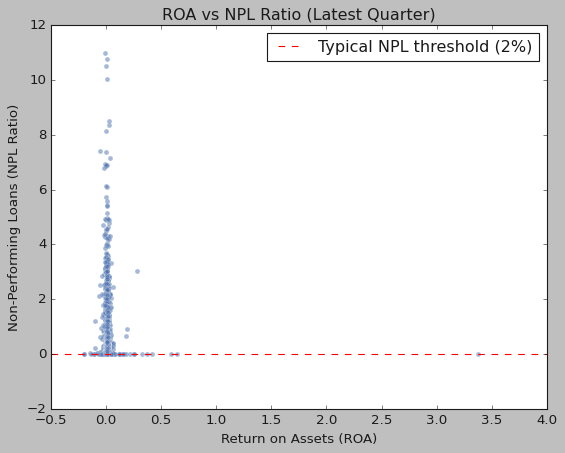

In [123]:
# Scatterplot; Risk vs Profitability
plt.figure(figsize=(8,6))
sns.scatterplot(x="roa", y="npl_ratio", data=df_snapshot, alpha=0.5)
plt.title("ROA vs NPL Ratio (Latest Quarter)")
plt.xlabel("Return on Assets (ROA)")
plt.ylabel("Non-Performing Loans (NPL Ratio)")
plt.axhline(0.02, color="red", linestyle="--", label="Typical NPL threshold (2%)")
plt.legend()
plt.show()


### Linking Profitability and Credit Risk

This scatterplot compares **ROA vs NPL Ratio**.  
- Healthy banks cluster around **positive ROA with low NPLs (<2%)**.  
- Troubled banks appear in the quadrant with **negative ROA and high NPLs**.

This kind of view is what credit analysts use to flag banks that may be **under stress** or at risk of failure.


In [124]:
query = """
SELECT b.state, AVG(f.roa) as avg_roa, AVG(f.roe) as avg_roe, AVG(f.capital_ratio) as avg_capital
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
WHERE f.date_id = (SELECT MAX(date_id) FROM bank_kpi_fact)
GROUP BY b.state
ORDER BY avg_roa DESC;
"""
df_state = pd.read_sql(query, engine)
df_state.head(10)


,state,avg_roa,avg_roe,avg_capital
0,NV,0.030370,0.163357,0.136632
1,OH,0.029246,0.083004,0.121255
2,DE,0.023487,0.139935,0.258932
3,VI,0.021670,0.611376,0.035445
4,UT,0.020251,0.158833,0.140174
5,NM,0.016805,0.198326,0.117732
6,MT,0.016109,0.132584,0.119695
7,FM,0.015234,0.126782,0.120159
8,GA,0.013586,0.129606,0.105727
9,MO,0.012189,0.130882,0.106450


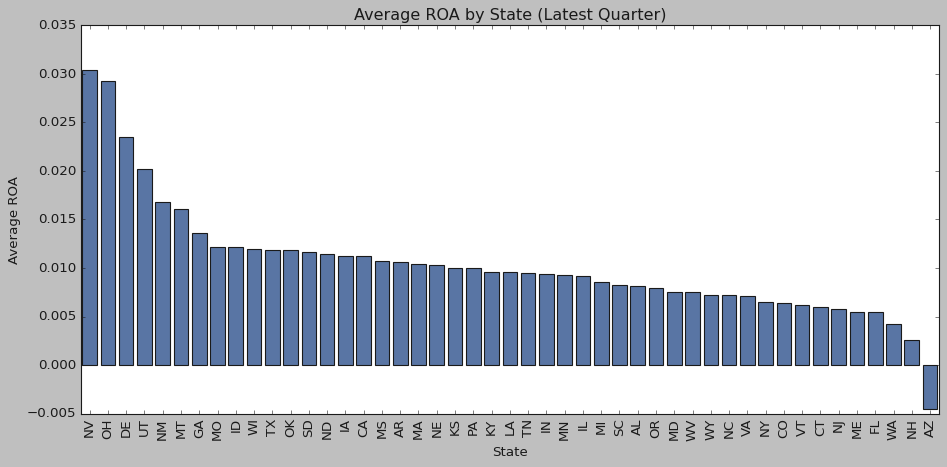

In [125]:
state_sql = """
SELECT b.state,
       AVG(f.roa) AS avg_roa,
       AVG(f.roe) AS avg_roe,
       AVG(f.capital_ratio) AS avg_capital,
       AVG(f.npl_ratio) AS avg_npl
FROM bank_kpi_fact f
JOIN bank_dim b ON f.bank_id = b.bank_id
WHERE f.date_id = (SELECT MAX(date_id) FROM bank_kpi_fact)
GROUP BY b.state
HAVING COUNT(*) > 10  -- drop states with too few banks
ORDER BY avg_roa DESC;
"""
df_state = pd.read_sql(state_sql, engine)

plt.figure(figsize=(12,6))
sns.barplot(x="state", y="avg_roa", data=df_state.sort_values("avg_roa", ascending=False))
plt.title("Average ROA by State (Latest Quarter)")
plt.xlabel("State")
plt.ylabel("Average ROA")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Geographic Lens

By aggregating KPIs at the **state level**, I can spot regional differences:  
- Some states show consistently higher capital ratios, signaling more conservative banking practices.  
- Others show weaker ROA/ROE, possibly due to local economic conditions.

Business Application:  
This provides regulators or investors with a way to compare **systemic risk across regions**, a key part of stress-testing exercises.


## Top 10/ Bottom 10 Banks by ROA (latest quarter)

In [145]:
latest_q = df["date_id"].max()
latest = df[df["date_id"] == latest_q].copy()

# Top 10 banks by ROA (strongest)
top10 = latest.nlargest(10, "roa")[["name","state","roa","roe","npl_ratio","capital_ratio","nim"]]

print(f"Latest quarter: {latest_q.date()}")
print("\nTop 10 by ROA")
display(top10)


Latest quarter: 2024-12-31

Top 10 by ROA


,name,state,roa,roe,npl_ratio,capital_ratio,nim
15251,FDS BANK,OH,3.377840,9.821330,0.000000,0.343929,0.037564
115196,ITS BANK,IA,0.644965,0.668391,0.000000,0.964951,0.036633
115285,CAPITAL BANK AND TRUST COMPANY,CA,0.588983,1.066899,0.000000,0.552051,0.025057
113702,BOSTON TRUST & INVESTMENT MANAGEMENT COMPANY,MA,0.416772,0.606662,0.000000,0.686992,0.012937
115757,NORTHWESTERN MUTUAL WEALTH MANAGEMENT,WI,0.372327,0.611492,0.000000,0.608882,0.042900
115314,SEI PRIVATE TRUST COMPANY,PA,0.329602,0.353306,0.000000,0.932908,0.025834
114265,"CREDIT ONE BANK, NATIONAL ASSOCIATION",NV,0.284569,0.920857,3.038673,0.309027,0.192407
115091,CREDIT FIRST NATIONAL ASSOCIATION,OH,0.257683,0.267822,0.000000,0.962140,-0.000447
115287,"FIDELITY PERSONAL TRUST COMPANY, FSB",MA,0.253725,0.265775,0.000000,0.954663,0.057571
115349,COUNTRY TRUST BANK,IL,0.219511,0.251010,0.000000,0.874512,0.034535


### Takeaway(Top 10):
High ROA with moderate NPL suggests resilient profitability and disciplined credit.

In [147]:
# Bottom 10 banks by ROA (latest quarter)
latest_q = df['date_id'].max()
latest = df[df["date_id"] == latest_q].copy()

# Bottom 10 banks by ROA (weakest)
bottom10 = latest.nsmallest(10, "roa")[["name","state","roa","roe","npl_ratio","capital_ratio","nim"]]

print(f"Latest quarter: {latest_q.date()}")
print("\nBottom 10 by ROA")
display(bottom10)


Latest quarter: 2024-12-31

Bottom 10 by ROA


,name,state,roa,roe,npl_ratio,capital_ratio,nim
116202,ALTOS BANK,CA,-0.203166,-0.225193,0.000000,0.902186,0.004636
115806,INDEPENDENCE BANK,RI,-0.201751,-0.249135,0.000000,0.809807,0.053240
116166,"VARO BANK, NATIONAL ASSOCIATION",UT,-0.145156,-1.081674,0.052947,0.134196,0.022872
116205,GALA BANK,FL,-0.133655,-0.134446,0.000000,0.994118,0.000000
112918,COLORADO NATIONAL BANK,CO,-0.111791,-0.671258,0.000000,0.166539,0.031197
114392,YOUNG AMERICANS BANK,CO,-0.106226,-1.078824,0.005792,0.098465,0.032030
115902,PARAMOUNT BANK,MO,-0.097933,-1.196031,1.214665,0.081882,0.021394
113277,MAXWELL STATE BANK,IA,-0.096976,-1.407612,0.207232,0.068894,0.026898
114588,SUNNYSIDE FEDERAL SAVINGS AND LOAN ASSOCIATION...,NY,-0.080903,-0.690304,0.057667,0.117199,0.034216
113781,FIRST STATE BANK,OK,-0.070569,-1.282473,0.044160,0.055026,0.031730


### Takeaway (Bottom 10): 
Persistent low ROA with above-median NPL flags credit-risked banks to monitor.

### Summary Insights

- **Profitability is cyclical (ROA & ROE):** Banks show seasonal patterns. Average ROA dipped to ~0.27% in early 2024, then recovered to ~1.1% by year-end. ROE followed, finishing near 9.4%.  
  *Context:* Reflects rising rates and higher loan loss provisions.

- **Capital adequacy is stable:** Ratios averaged ~11% of assets across quarters. Even during profit dips, banks preserved sufficient equity buffers.  
  *Why it matters:* Adequate capital is a regulatory safeguard against insolvency risk.

- **NIM tightened then rebounded:** Fell to ~0.8% in early 2024, rebounded to ~3.3% by Q4.  
  *Context:* Reflects sensitivity to Fed rate hikes and deposit competition.

- **Credit quality deteriorated:** NPL ratios rose through 2024, reaching ~0.52%.  
  *Implication:* While still moderate, the upward trend signals growing loan book stress.

- **Variation across banks/regions:** Some banks show extreme ROE (~40%) or negative equity. State-level benchmarking is needed (next step).






**Why this matters:**
- Regulators: Pinpoint system-wide stress (profitability dips, rising NPLs).
- Investors/analysts: Use as benchmarks for peer comparisons.
- Bank management: Focus on interest-rate sensitivity and credit quality risks.


**Next Steps:**
1. Expand with state-level breakdowns and peer benchmarks.
2. Build Tableau dashboards for interactive KPI tracking.
3. Overlay macro indicators (CPI, unemployment, Fed Funds Rate) for context.


**Overall:** This analysis demonstrates end-to-end skills in data ingestion, modeling, KPI transformation, EDA, and visualization — answering the business question: *Which banks and regions are most at risk based on profitability, capital adequacy, and credit quality?*
